In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm


In [82]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'

# sex = 'chrXY'
# sex = 'chrX'
# sex = 'chrY'
# sex = 'autosome'

value_to_predict = 'Sex'

organ = "HEART"
sex= 'autosome'


In [83]:

with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')


features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]


In [125]:
data_train = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)
data_train = data_train[features_list.index]


data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
data_train['sex'] = data_header['Sex']
data_train


,ENST00000372476.8,MSTRG.1913.3,MSTRG.21565.12,MSTRG.1168.1,MSTRG.13450.7,MSTRG.21565.11,MSTRG.17871.5,ENST00000300184.8,ENST00000413366.8,ENST00000246080.4,...,MSTRG.9702.3,ENST00000372987.8,MSTRG.6310.11,MSTRG.813.69,ENST00000392008.6,MSTRG.31035.16,ENST00000331581.11,ENST00000553708.5,ENST00000426395.7,sex
ERR188021,0.371820,1.879362,0.000000,0.448089,0.331404,0.346092,0.000000,0.693165,0.981270,0.777719,...,3.194446,0.544637,0.000000,2.395691,1.043788,0.473281,0.029700,0.000000,1.941098,F
ERR188022,0.000000,0.561952,0.000000,0.343467,0.312306,0.302993,0.000000,1.554989,0.036522,0.256587,...,0.000000,0.771966,0.002426,2.287521,0.701596,1.066574,1.410393,2.154291,0.052954,M
ERR188023,0.524604,0.169051,1.471592,1.178407,0.021934,0.929705,0.012570,0.813395,0.131450,0.397523,...,4.174785,0.000000,2.194881,0.048921,4.235679,1.427488,0.000000,0.796461,0.251772,F
ERR188024,0.000000,1.068493,0.000000,1.179953,0.000000,0.057898,0.000000,0.000000,0.169784,0.000000,...,4.057852,0.000000,0.608426,0.000000,0.173652,0.000000,1.602816,1.883474,1.990728,F
ERR188025,0.000000,0.495171,0.000000,0.717738,0.433328,1.369905,0.000000,0.161968,0.126303,1.538842,...,0.000000,0.224697,0.000000,0.127256,1.033112,0.566476,0.056117,0.000000,0.824826,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR204940,0.000000,0.000000,0.000000,2.946633,1.121803,0.000000,0.000000,0.000000,3.185858,2.738430,...,0.000000,2.249973,0.442946,0.000000,0.000000,0.000000,3.180119,0.000000,0.000000,F
ERR205020,1.593257,0.251156,0.000000,0.126522,0.000000,0.279521,0.001527,0.636723,0.150324,0.736191,...,0.000000,0.230335,0.244719,0.247456,0.115513,0.888003,1.731710,0.321248,0.489444,M
ERR205021,0.831338,0.761626,0.000000,0.595642,1.535681,0.700445,0.000000,0.000000,3.015059,0.000000,...,1.602585,5.175067,0.030805,0.525416,0.146914,0.000000,0.147242,1.759293,0.777570,M
ERR205022,1.753175,0.446840,0.000000,0.000000,0.132270,0.074429,0.000000,0.000000,0.063528,0.593497,...,4.673975,0.000000,0.590139,2.201288,0.231242,1.226098,0.183334,1.001822,1.353977,F


In [84]:
X = data_eval.values
X = RobustScaler().fit_transform(X)

y = data_eval_header['sex'].values
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

# y = (dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values

predicted:    [0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]
--------------------
mean_auc=0.3828282828282828,
mean_accuracy=0.5,
mean_f1=0.3555555555555555,
mean_precision=0.4222222222222222,
mean_recall=0.31111111111111106,
--------------------
```


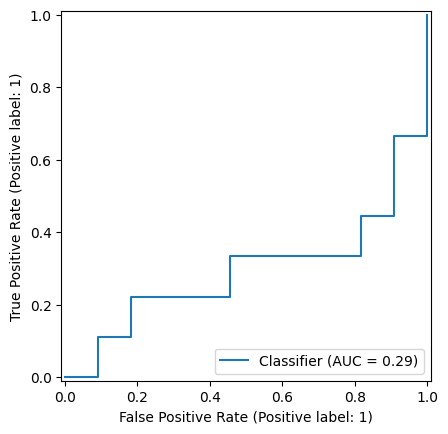

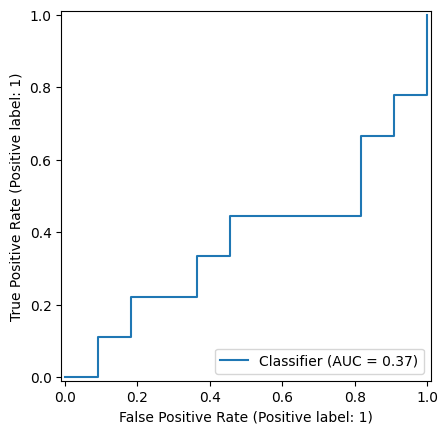

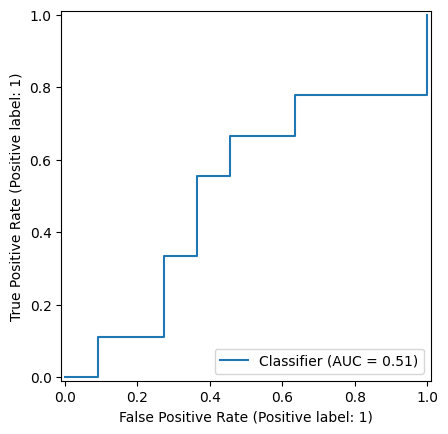

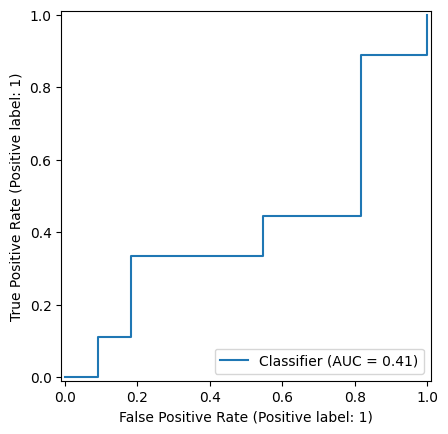

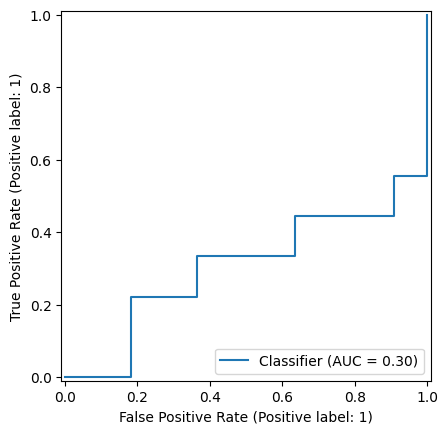

In [85]:
proba = np.zeros(shape=(X.shape[0], 2))
pred = np.zeros(shape=(X.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(5):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X)
    pred_ = model.predict(X)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y, pred_))
    f1.append(f1_score(y, pred_))
    precisions.append(precision_score(y, pred_))
    recalls.append(recall_score(y, pred_))

    viz = RocCurveDisplay.from_predictions(
        y, model.predict_proba(X)[:, 1],
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)

proba = proba / 5
# pred = pred / 5
print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

In [86]:
proba[:, 1]

array([0.27220809, 0.13716225, 0.23862787, 0.59021615, 0.53947833,
       0.31351734, 0.81949002, 0.18318942, 0.18252071, 0.92370017,
       0.1866321 , 0.1826291 , 0.05446743, 0.01075386, 0.10581322,
       0.84451603, 0.65481769, 0.39736112, 0.10425968, 0.49408552])

In [118]:
# data_eval_header
test_header = data_eval_header.copy(deep=True)
# test_header['test_prediction'] = (proba[:, 1] > 0.5).astype(int)
test_header['sex_prediction'] = pred/5
test_header['sex_proba'] = proba[:, 1]

# test_header['sex']
features_list

,SHAP
ENST00000372476.8,50
MSTRG.1913.3,50
MSTRG.21565.12,49
MSTRG.1168.1,49
MSTRG.13450.7,47
...,...
ENST00000392008.6,15
MSTRG.31035.16,15
ENST00000331581.11,15
ENST00000553708.5,15


In [88]:
dataset = test_header[['cardiac_chamber', 'sex_prediction', 'sex_proba', 'sex']]
dataset

,cardiac_chamber,sex_prediction,sex_proba,sex
0,Right ventricle,0.0,0.272208,female
1,Left ventricle,0.0,0.137162,female
2,Right atrium,0.2,0.238628,female
3,Left atrium,0.8,0.590216,female
4,Right atrium,0.6,0.539478,female
5,Right ventricle,0.2,0.313517,female
6,Left atrium,1.0,0.819490,female
7,Right ventricle,0.0,0.183189,female
8,Left ventricle,0.0,0.182521,female
9,Right atrium,1.0,0.923700,female


In [93]:
(dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values


dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Right ", "")
dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Left ", "")
# dataset

/tmp/ipykernel_97576/1602482625.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Right ", "")
/tmp/ipykernel_97576/1602482625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['cardiac_chamber'] = dataset['cardiac_chamber'].str.replace("Left ", "")


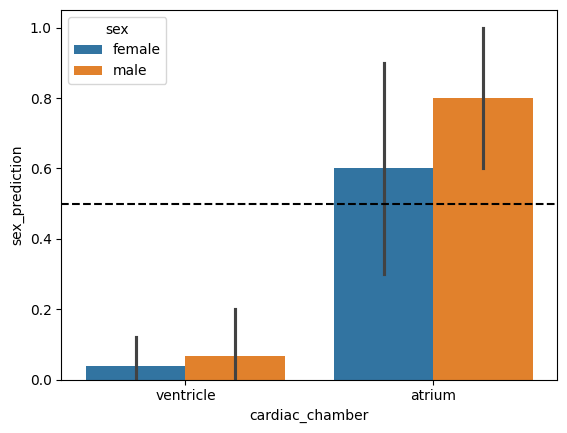

In [94]:
g = sns.barplot(dataset, x='cardiac_chamber', y='sex_prediction', hue='sex')
g.axhline(0.5, color='black', linestyle='dashed')
# plt.hlines(0.5, 0, 1)

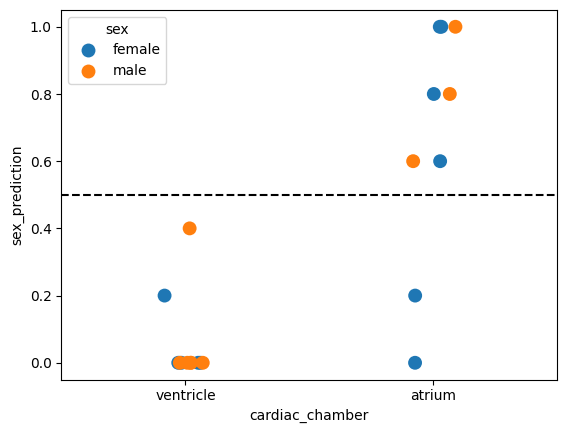

In [103]:
g =  sns.stripplot(dataset, x='cardiac_chamber', y='sex_prediction', hue='sex', size=10)
g.axhline(0.5, color='black', linestyle='dashed')


In [109]:
data_research = data_eval.copy(deep=True)

dataset.set_index(data_research.index, inplace=True)
data_research['cardiac_chamber'] = dataset['cardiac_chamber'] 

In [131]:
plt.subplots(figsize=(10,80))
sns.boxplot(data=data_research.melt('cardiac_chamber'), x='value', y="variable", hue='cardiac_chamber')

In [132]:
plt.subplots(figsize=(10,80))
sns.boxplot(data=data_train.melt("sex"), x='value', y="variable", hue='sex')

In [149]:
from sklearn.decomposition import PCA
import umap


<Axes: >

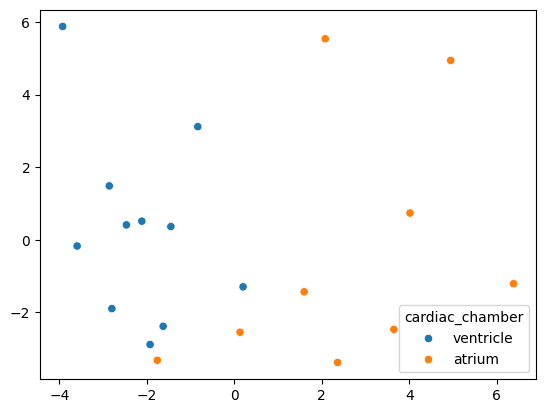

In [155]:
scaler = PCA(2)
# scaler = umap.UMAP(2)
scaler.fit(
    StandardScaler().fit_transform(data_research.drop(columns='cardiac_chamber').values)
    )
pca_eval = scaler.transform(
    StandardScaler().fit_transform(data_research.drop(columns='cardiac_chamber').values)
    )
sns.scatterplot(x=pca_eval[:,0], y=pca_eval[:,1], hue=data_research['cardiac_chamber'])



<Axes: >

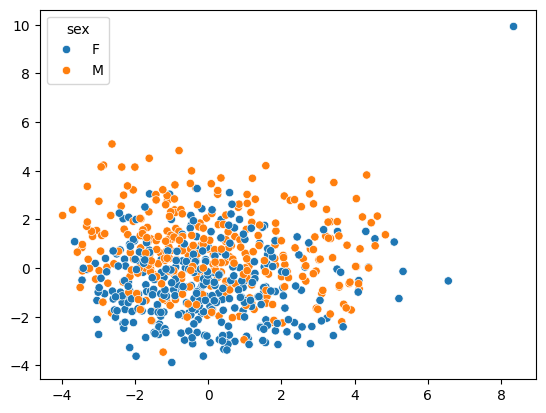

In [157]:
scaler = PCA(2)
# scaler = umap.UMAP(2)
scaler.fit(
    StandardScaler().fit_transform(data_train.drop(columns='sex').values)
    )
pca_train = scaler.transform(
    StandardScaler().fit_transform(data_train.drop(columns='sex').values)
    )
sns.scatterplot(x=pca_train[:,0], y=pca_train[:,1], hue=data_train['sex'])

